# Analytic check

In [1]:
import sympy as sp
import numpy as np
import scipy.special as sc
import matplotlib.pyplot as plt

import aurel
#from aurel.solutions import Collins_Stewart as sol
#from aurel.solutions import Conformally_flat as sol
from aurel.solutions import Harvey_Tsoubelis as sol
#from aurel.solutions import Non_diagonal as sol
#from aurel.solutions import Rosquist_Jantzen as sol
#from aurel.solutions import Schwarzschild as sol #too long for analytics
#from aurel.solutions import Szekeres as sol #too long for analytics

In [2]:
#Analytical setup
t, x, y, z = sp.symbols('t x y z')

# Spacetime
g = sol.gdown4(t, x, y, z, analytical=True)
an4 = aurel.AurelCoreSymbolic([t, x, y, z])
an4.data['gdown'] = g

# Space
gamma = sol.gammadown3(t, x, y, z, analytical=True)
an3 = aurel.AurelCoreSymbolic([x, y, z])
an3.data['gdown'] = gamma

In [3]:
# Numerical setup

L = 20
N = 64
grid = {
    'Nx': N,  # Number of data points per side
    'Ny': N,
    'Nz': N,
    'xmin': - L / 2 + 0.01,  # Minimum x coordinate
    'ymin': - L / 2 + 0.01,  # Minimum y coordinate
    'zmin': - L / 2 + 0.01,  # Minimum z coordinate
    'dx': L / N,  # Elementary grid size
    'dy': L / N,
    'dz': L / N,
}
fd = aurel.FiniteDifference(grid, boundary='other', fd_order=8)
rel = aurel.AurelCore(fd) # Need to pass Lambda=sol.Lambda if != 0.0

nt = 1
nx, ny, nz = fd.cartesian_coords

rel.data = sol.data(nt, nx, ny, nz)
rel.freeze_data()

8th order finite difference schemes are defined


<IPython.core.display.Latex object>

In [4]:
err_max = 1e-4

custom_funcs = {
    "hyper": lambda a, b, z: sc.hyp2f1(a[0], a[1], b[0], z),
    "exp_polar": np.exp}
def compare_values(theory, numerical):
    f_num = sp.lambdify((t, x, y, z), theory, modules=[custom_funcs, "numpy"])
    s1 = np.real(f_num(nt, fd.cutoffmask(nx), fd.cutoffmask(ny), fd.cutoffmask(nz)))
    s2 = fd.cutoffmask(numerical)
    if theory != 0:
        rel_err = np.abs(aurel.maths.safe_division(s2 - s1, s1))
        error = np.max(np.ma.masked_invalid(rel_err))
    else:
        error = np.max(np.abs(s2))
    return error

def checks(var, theory, numerical):
    error = compare_values(theory, numerical)
    if error > err_max:
        print(var, 
              f", max(abs(num_val)) = ", np.max(abs(fd.cutoffmask(numerical))), 
              ", relative error =", error)

def check1d(dim, var, theory, numerical):
    for i in range(dim):
        checks(var+f"{i}", theory[i], numerical[i])

def check2d(dim, var, theory, numerical):
    for i in range(dim):
        for j in range(dim):
            checks(var+f"{i}{j}", theory[i, j], numerical[i, j])

def check3d(dim, var, theory, numerical):
    for i in range(dim):
        for j in range(dim):
            for k in range(dim):
                checks(var+f"{i}{j}{k}", theory[i, j, k], numerical[i, j, k])
def check4d(dim, var, theory, numerical):
    for i in range(dim):
        for j in range(dim):
            for k in range(dim):
                for l in range(dim):
                    checks(var+f"{i}{j}{k}{l}", theory[i, j, k, l], numerical[i, j, k, l])

def plot_them(analytical, numerical, cutoff=True):
    f_num = sp.lambdify((t, x, y, z), analytical, modules=[custom_funcs, "numpy"])
    A = np.real(f_num(nt, nx, ny, nz))
    if isinstance(A, int) or isinstance(A, float):
        A = np.full_like(numerical, A)

    rel_error = np.abs(aurel.maths.safe_division(numerical - A, A))
    ix, iy, iz = np.where(rel_error == np.max(rel_error))
    if len(ix) > 1:
        ix = ix[0]
        iy = iy[0]
        iz = iz[0]
    print("max {:.2e} error at".format(np.max(rel_error)), ix, iy, iz)
    if iy < 2*fd.mask_len or iz < 2*fd.mask_len:
        cutoff = False
        print('Max relative difference in boundary region')

    if cutoff:
        xv = fd.cutoffmask(fd.xarray)
        nv = fd.cutoffmask(numerical[:,iy,iz])
        av = fd.cutoffmask(A[:,iy,iz])
        rv = fd.cutoffmask(rel_error[:,iy,iz])
    else:
        xv = fd.xarray
        nv = numerical[:,iy,iz]
        av = A[:,iy,iz]
        rv = rel_error[:,iy,iz]

    plt.figure()
    plt.subplot(211)
    plt.plot(xv, nv, 
             label="numerical")
    plt.plot(xv, av, 
             linestyle='--',
             label="analytical")
    plt.grid()
    plt.legend()
    plt.subplot(212)
    plt.semilogy(xv, rv)
    plt.grid()
    plt.ylabel("relative difference")
    plt.xlabel("x")
    plt.subplots_adjust(hspace=0.0)

## Check Christoffel symbols

### 3D

In [5]:
check2d(3, "gamma^", an3["gup"], rel["gammaup3"])

check3d(3, "Γudd", an3["Gamma_udd"], rel["s_Gamma_udd3"])

Calculated symbolic gup: Metric tensor in the up index form


<IPython.core.display.Latex object>

Calculated symbolic Gamma_udd: Christoffel symbols in the up-down-down index form


<IPython.core.display.Latex object>

Γudd022 , max(abs(num_val)) =  208116.36229624215 , relative error = 0.0016382525191416827
Γudd202 , max(abs(num_val)) =  4.723738844061859 , relative error = 0.0001341854370830323
Γudd220 , max(abs(num_val)) =  4.723738844061859 , relative error = 0.0001341854370830323


### 4D

In [6]:
check2d(4, "g^", an4["gup"], rel["gup4"])
check3d(4, "Γudd", an4["Gamma_udd"], rel["st_Gamma_udd4"])

Calculated symbolic gup: Metric tensor in the up index form


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Calculated symbolic Gamma_udd: Christoffel symbols in the up-down-down index form


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Γudd133 , max(abs(num_val)) =  208116.36229624215 , relative error = 0.0016382525191416827
Γudd313 , max(abs(num_val)) =  4.723738844061859 , relative error = 0.0001341854370830323
Γudd331 , max(abs(num_val)) =  4.723738844061859 , relative error = 0.0001341854370830323


## Check Riemann and Ricci

### 3D

In [7]:
# Compute 3-Riemann tensor: R^i_{jkl}
check4d(3, "Ruddd", an3["Riemann_uddd"], rel["s_Riemann_uddd3"])

0 1 0 1,  0 1 0 2,  0 1 1 2,  0 2 0 1,  0 2 0 2,  0 2 1 2,  1 0 0 1,  1 0 0 2,  1 0 1 2,  1 2 0 1,  1 2 0 2,  1 2 1 2,  2 0 0 1,  2 0 0 2,  2 0 1 2,  2 1 0 1,  2 1 0 2,  2 1 1 2,  
Calculated symbolic Riemann_uddd: Riemann curvature tensor in the up-down-down-down index form


<IPython.core.display.Latex object>

Ruddd0101 , max(abs(num_val)) =  0.016679485081112944 , relative error = 0.016679485081112944
Ruddd0102 , max(abs(num_val)) =  2331.4100690063497 , relative error = 0.0001242683747693139
Ruddd0110 , max(abs(num_val)) =  0.016679485081303968 , relative error = 0.016679485081303968
Ruddd0120 , max(abs(num_val)) =  2331.4100690063483 , relative error = 0.000124268374769899
Ruddd0201 , max(abs(num_val)) =  2331.4100690064515 , relative error = 0.00012426837472562759
Ruddd0202 , max(abs(num_val)) =  44052.60137026294 , relative error = 0.00014654071619464928
Ruddd0210 , max(abs(num_val)) =  2331.41006900645 , relative error = 0.00012426837472621268
Ruddd0220 , max(abs(num_val)) =  44052.601370262935 , relative error = 0.00014654071619464928
Ruddd1001 , max(abs(num_val)) =  4.372981885582807 , relative error = 0.0006823536802762492
Ruddd1010 , max(abs(num_val)) =  4.372981885582807 , relative error = 0.0006823536802762492
Ruddd1112 , max(abs(num_val)) =  0.08309351022762712 , relative error 

In [8]:
# Lower the first index: R_{lijk} = γ_{lm} R^m_{ijk}
check4d(3, "R_", an3["Riemann_down"], rel["s_Riemann_down3"])

0 1 0 1,  0 1 0 2,  0 1 1 2,  0 2 0 2,  0 2 1 2,  1 2 1 2,  
Calculated symbolic Riemann_down: Riemann curvature tensor in the down index form


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

R_0101 , max(abs(num_val)) =  0.016679485081112944 , relative error = 0.016679485081112944
R_0102 , max(abs(num_val)) =  2331.4100690063497 , relative error = 0.0001242683747693139
R_0110 , max(abs(num_val)) =  0.016679485081303968 , relative error = 0.016679485081303968
R_0120 , max(abs(num_val)) =  2331.4100690063483 , relative error = 0.000124268374769899
R_0201 , max(abs(num_val)) =  2331.4100690064515 , relative error = 0.00012426837472562759
R_0202 , max(abs(num_val)) =  44052.60137026294 , relative error = 0.00014654071619464928
R_0210 , max(abs(num_val)) =  2331.41006900645 , relative error = 0.00012426837472621268
R_0220 , max(abs(num_val)) =  44052.601370262935 , relative error = 0.00014654071619464928
R_1001 , max(abs(num_val)) =  0.01412428077706889 , relative error = 0.01412428077706889
R_1002 , max(abs(num_val)) =  2331.913775963813 , relative error = 0.00016553528610018482
R_1010 , max(abs(num_val)) =  0.01412428077488208 , relative error = 0.01412428077488208
R_1020 , m

In [9]:
check2d(3, "R_", an3["Ricci_down"], rel["s_Ricci_down3"])

Calculated symbolic Ricci_down: Ricci curvature tensor in the down index form


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

R_00 , max(abs(num_val)) =  1.003148449103068 , relative error = 0.003148449103067996
R_11 , max(abs(num_val)) =  0.026515946792642336 , relative error = 0.026515946792642336
R_12 , max(abs(num_val)) =  2331.326975496122 , relative error = 0.00015990482733364868
R_21 , max(abs(num_val)) =  2331.326975496122 , relative error = 0.00015990482733364868
R_22 , max(abs(num_val)) =  44051.88960137361 , relative error = 0.00020066236838926717


In [10]:
checks("R", an3["RicciS"], rel["s_RicciS"])

Calculated symbolic RicciS: Ricci scalar


<IPython.core.display.Latex object>

R , max(abs(num_val)) =  2.0054514864455992 , relative error = 0.002725743222799615


max 1.18e-01 error at [0] [0] [0]
Max relative difference in boundary region


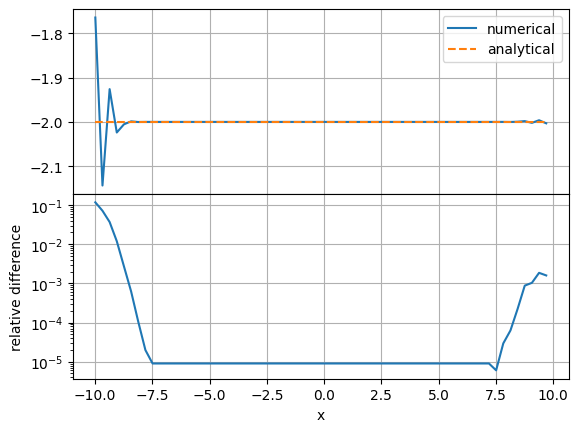

In [11]:
plot_them(an3["RicciS"], rel["s_RicciS"])

### 4D

In [12]:
check4d(4, "Ruddd", an4["Riemann_uddd"], rel["st_Riemann_uddd4"])

0 1 0 1,  0 1 0 2,  0 1 0 3,  0 1 1 2,  0 1 1 3,  0 1 2 3,  0 2 0 1,  0 2 0 2,  0 2 0 3,  0 2 1 2,  0 2 1 3,  0 2 2 3,  0 3 0 1,  0 3 0 2,  0 3 0 3,  0 3 1 2,  0 3 1 3,  0 3 2 3,  1 0 0 1,  1 0 0 2,  1 0 0 3,  1 0 1 2,  1 0 1 3,  1 0 2 3,  1 2 0 1,  1 2 0 2,  1 2 0 3,  1 2 1 2,  1 2 1 3,  1 2 2 3,  1 3 0 1,  1 3 0 2,  1 3 0 3,  1 3 1 2,  1 3 1 3,  1 3 2 3,  2 0 0 1,  2 0 0 2,  2 0 0 3,  2 0 1 2,  2 0 1 3,  2 0 2 3,  2 1 0 1,  2 1 0 2,  2 1 0 3,  2 1 1 2,  2 1 1 3,  2 1 2 3,  2 3 0 1,  2 3 0 2,  2 3 0 3,  2 3 1 2,  2 3 1 3,  2 3 2 3,  3 0 0 1,  3 0 0 2,  3 0 0 3,  3 0 1 2,  3 0 1 3,  3 0 2 3,  3 1 0 1,  3 1 0 2,  3 1 0 3,  3 1 1 2,  3 1 1 3,  3 1 2 3,  3 2 0 1,  3 2 0 2,  3 2 0 3,  3 2 1 2,  3 2 1 3,  3 2 2 3,  
Calculated symbolic Riemann_uddd: Riemann curvature tensor in the up-down-down-down index form


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Ruddd0101 , max(abs(num_val)) =  0.0031484491030582262 , relative error = 0.0031484491030582262
Ruddd0110 , max(abs(num_val)) =  0.0031484491030582262 , relative error = 0.0031484491030582262
Ruddd0123 , max(abs(num_val)) =  0.01262044790564687 , relative error = 0.01262044790564687
Ruddd0132 , max(abs(num_val)) =  0.01262044790564687 , relative error = 0.01262044790564687
Ruddd0203 , max(abs(num_val)) =  19697.40712642635 , relative error = 0.0003891806778538999
Ruddd0230 , max(abs(num_val)) =  19697.40712642635 , relative error = 0.0003891806778538999
Ruddd0302 , max(abs(num_val)) =  19697.40712642635 , relative error = 0.0003891806778538999
Ruddd0303 , max(abs(num_val)) =  164064.5758265376 , relative error = 0.00020820998017207775
Ruddd0312 , max(abs(num_val)) =  19697.00558478495 , relative error = 0.000601699148547393
Ruddd0313 , max(abs(num_val)) =  164058.73499428353 , relative error = 0.0001017379136592247
Ruddd0320 , max(abs(num_val)) =  19697.40712642635 , relative error = 0

In [13]:
check4d(4, "R_", an4["Riemann_down"], rel["st_Riemann_down4"])

0 1 0 1,  0 1 0 2,  0 1 0 3,  0 1 1 2,  0 1 1 3,  0 1 2 3,  0 2 0 2,  0 2 0 3,  0 2 1 2,  0 2 1 3,  0 2 2 3,  0 3 0 3,  0 3 1 2,  0 3 1 3,  0 3 2 3,  1 2 1 2,  1 2 1 3,  1 2 2 3,  1 3 1 3,  1 3 2 3,  2 3 2 3,  
Calculated symbolic Riemann_down: Riemann curvature tensor in the down index form
R_0101 , max(abs(num_val)) =  0.0031484491030582262 , relative error = 0.0031484491030582262
R_0110 , max(abs(num_val)) =  0.0031484491030582262 , relative error = 0.0031484491030582262
R_0123 , max(abs(num_val)) =  0.01262044790564687 , relative error = 0.01262044790564687
R_0132 , max(abs(num_val)) =  0.01262044790564687 , relative error = 0.01262044790564687
R_0203 , max(abs(num_val)) =  19697.40712642635 , relative error = 0.0003891806778538999
R_0230 , max(abs(num_val)) =  19697.40712642635 , relative error = 0.0003891806778538999
R_0302 , max(abs(num_val)) =  19697.40712642635 , relative error = 0.0003891806778538999
R_0303 , max(abs(num_val)) =  164064.5758265376 , relative error = 0.0002082

max 1.04e-02 error at 0 1 0
Max relative difference in boundary region


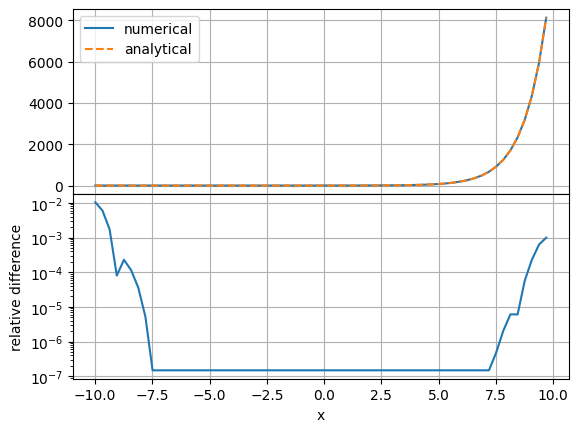

In [14]:
plot_them(an4["Riemann_down"][2,1,2,1], rel["st_Riemann_down4"][2,1,2,1])

In [15]:
check2d(4, "R_", an4["Ricci_down"], rel["st_Ricci_down4"])

Calculated symbolic Ricci_down: Ricci curvature tensor in the down index form


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [16]:
checks("R", an4["RicciS"], rel["st_RicciS"])

Calculated symbolic RicciS: Ricci scalar


<IPython.core.display.Latex object>